# Quadrotor Example



In [1]:
# If first time running this code on a personal computer
# using Pkg
# Pkg.instantiate()

### Script / GuSTO Initialization

In [2]:
# Initializing script
using LinearAlgebra
using Ipopt
using JuMP
using DifferentialEquations
using NLsolve
using Plots

include("./Models/quadrotor.jl")
include("./SCP/gusto_problem.jl")
include("quadrotor_plotting.jl")

# Number of time-discretization points and maximum number of GuSTO iterations
N, max_it = 30, 20

# Defining the model, the initial strategy and each convex subproblem
model      = Quadrotor()
Xp,Up      = initialize_trajectory(model,N)
SCPproblem = GuSTOProblem(model,N,Xp,Up)

# Defining GuSTO parameters
(Delta0, omega0, omegamax, epsilon, rho0,
        rho1, beta_succ, beta_fail, gamma_fail, 
        convergence_threshold) = get_initial_gusto_parameters(model)

(100.0, 500.0, 1.0e6, 0.001, 5.0, 10.0, 2.0, 0.5, 5.0, 2.5)

## GuSTO Algorithm

In [3]:
# Defining penalization weights, trust-region radius and the list of solutions
include("SCP/gusto_problem.jl")
Xp,Up        = initialize_trajectory(model,N)
X, U         = copy(Xp), copy(Up)
omega, Delta = omega0, Delta0
X_all, U_all = [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

# GuSTO loop
success, it = false, 1
while it < max_it                                                               && 
      !(success && convergence_metric(model,X,U,Xp,Up) < convergence_threshold) &&
      omega < omegamax
    println("-----------\nIteration $it\n-----------")
    
    # Storing the solution at the previous step and the linearized dynamics
    Xp, Up                    = copy(X), copy(U)
    model.f, model.A, model.B = compute_dynamics(model,Xp,Up)
    
    # Defining the convex subproblem
    reset_problem(     SCPproblem, model)
    set_parameters(    SCPproblem, model, Xp, Up, omega, Delta)
    define_cost(       SCPproblem, model)
    define_constraints(SCPproblem, model)
    
    # Solving the convex subproblem
    JuMP.optimize!(SCPproblem.solver_model)
    X_sol, U_sol = JuMP.value.(SCPproblem.X), JuMP.value.(SCPproblem.U)
    
    # -----------
    # GuSTO Logic
    
    # Trust-region constraints are satisfied
    if is_in_trust_region(model,X_sol,U_sol,Xp,Up,Delta)
        
        # Computing accuracy ratio rho
        rho = accuracy_ratio(SCPproblem,model,X_sol,U_sol,Xp,Up)

        # Too coarse linearization: reject solution
        if rho > rho1
            println("Reject solution (the linearization is too coarse).")
            Delta, omega = beta_fail*Delta, omega
            success      = false
        
        # Accepting solution
        else
            println("Accept solution.")
            X, U    = copy(X_sol), copy(U_sol)
            success = true
            
            # Check precision of linearization
            if rho < rho0
                Delta = min(beta_succ*Delta,Delta0) # Optimal / Precise 
            else
                Delta = Delta                       # Imprecise - bad
            end
            
            # Check satisfaction of state constraints
            if satisfies_state_inequality_constraints(SCPproblem,model,X_sol,U_sol,Xp,Up,Delta)
                # All constraints are satisfied - good
                omega = omega0
            else
                # State constraints are not satisfied: increase penalization weights
                println("Solution does not satisfy state constraints, increasing omega.")
                omega   = gamma_fail*omega
                success = false
            end
        end
        
    # Trust-region constraints are NOT satisfied
    else
        println("Reject solution (the trust region constraints are not satisfied).")
        Delta   = Delta
        omega   = gamma_fail*omega
        success = false
    end

    # Collecting the solution at each iteration
    push!(X_all,copy(X))
    push!(U_all,copy(U))
    it += 1
    
    println("Parameters:")
    println("omega  = $omega; Delta = $Delta")
    println("metric = $(convergence_metric(model,X,U,Xp,Up))")
end

print(">>> Finished <<<")

-----------
Iteration 1
-----------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Accept solution.
Parameters:
omega  = 500.0; Delta = 100.0
metric = 63.25741117408185
-----------
Iteration 2
-----------
Accept solution.
Parameters:
omega  = 500.0; Delta = 100.0
metric = 17.219903587998253
-----------
Iteration 3
-----------
Accept solution.
Parameters:
omega  = 500.0; Delta = 100.0
metric = 9.263742663870223
-----------
Iteration 4
-----------
Accept solution.
Parameters:
omega  = 500.0; Delta = 100.0
metric = 2.0209450319527758
>>> Finished <<<

# Plots

In [4]:
include("quadrotor_plotting.jl")

plt_final_angle_accel (generic function with 1 method)

## Plot of SCP iterations

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = plt_solutions(::GuSTOProblem, ::Quadrotor, ::Array{Any,1}, ::Array{Any,1}; xlims::Array{Float64,1}, ylims::Array{Float64,1}, figsize::Tuple{Int64,Int64}, B_plot_labels::Bool) at quadrotor_plotting.jl:58
└ @ Main /home/thomas/Documents/research/CSM/GuSTO_quad_astrobee/quadrotor_plotting.jl:58


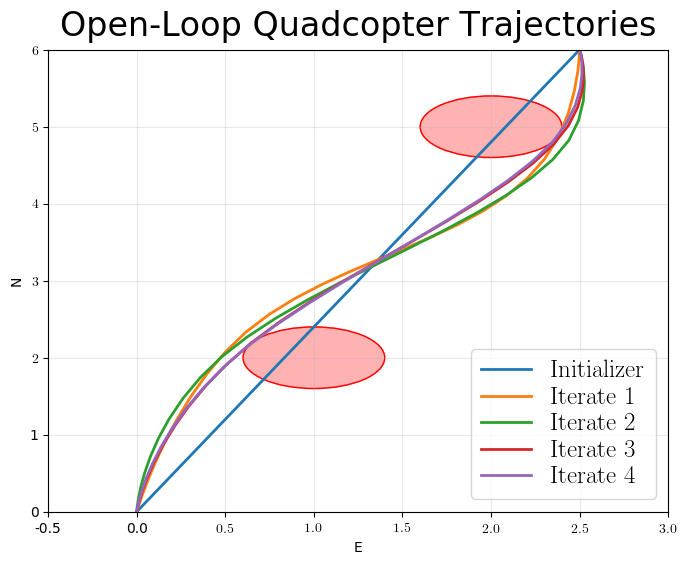

Done Plotting

In [5]:
plt_solutions(SCPproblem, model, X_all, U_all)
print("Done Plotting")

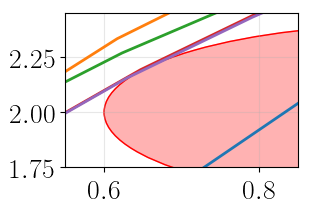

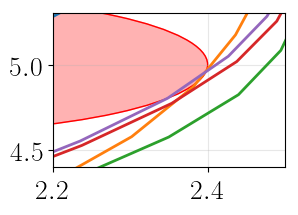

Done Plotting

In [6]:
plt_solutions(SCPproblem, model, X_all, U_all, 
                xlims=[0.55,0.85], ylims=[1.75,2.45], figsize=(3,2), B_plot_labels=false)
plt_solutions(SCPproblem, model, X_all, U_all, 
                xlims=[2.2,2.5], ylims=[4.4,5.3], figsize=(3,2), B_plot_labels=false)
print("Done Plotting")

## Multiple plots of the final solution

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = plt_final_solution(::GuSTOProblem, ::Quadrotor, ::Array{Float64,2}, ::Array{Float64,2}) at quadrotor_plotting.jl:110
└ @ Main /home/thomas/Documents/research/CSM/GuSTO_quad_astrobee/quadrotor_plotting.jl:110


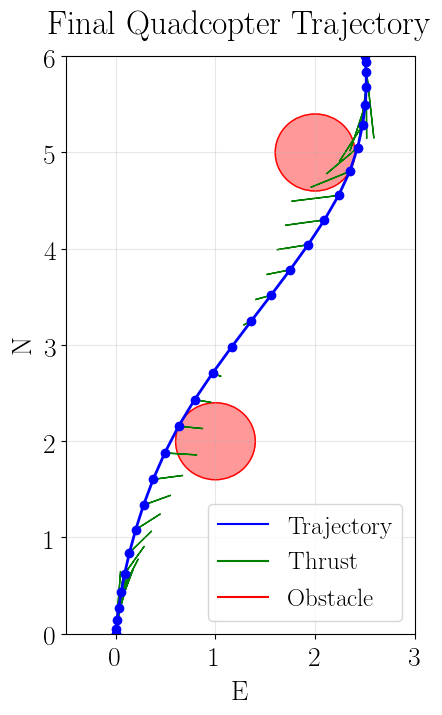

Done Plotting

In [7]:
plt_final_solution(SCPproblem, model, X_all[end], U_all[end])
print("Done Plotting")

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = plt_final_angle_accel(::GuSTOProblem, ::Quadrotor, ::Array{Float64,2}, ::Array{Float64,2}) at quadrotor_plotting.jl:178
└ @ Main /home/thomas/Documents/research/CSM/GuSTO_quad_astrobee/quadrotor_plotting.jl:178


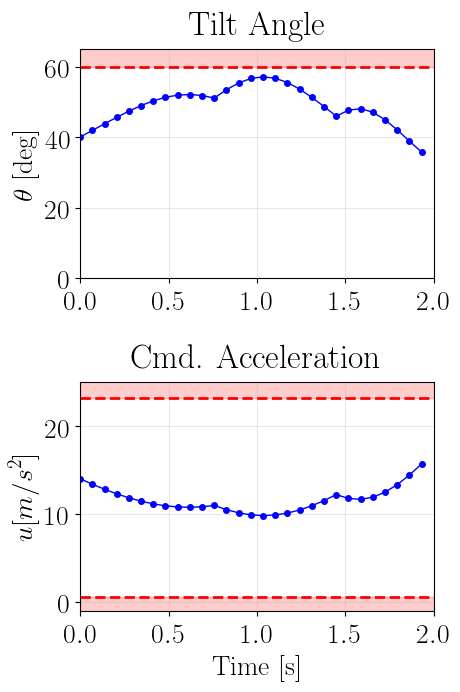

Done Plotting

In [8]:
plt_final_angle_accel(SCPproblem, model, X_all[end], U_all[end])
print("Done Plotting")